In [1]:
import os
import numpy as np
import hdf5storage as sio
import pathlib
nn_path = pathlib.Path.cwd().parent.resolve()

# Load connectivity data
conn_66 = sio.loadmat(os.path.join(nn_path, "data", "h66.mat"))
weights = conn_66['weights']
tract_lengths = conn_66['tract_lengths']

n_rois = weights.shape[0]
print(f'Number of regions of interest = {n_rois}')

Number of regions of interest = 66


In [2]:
from neuronumba.simulator.models import Naskar2021
from neuronumba.simulator.connectivity import Connectivity

# Create the connectivity data for the simulation
con = Connectivity(weights=weights, lengths=tract_lengths, speed=1e10)
# Use the Naskar model
m = Naskar2021(g=1.0)
print(f"Naskar state variables = {m.get_state_vars}, and observable variables = {m.get_observablevars}")

Naskar state variables = {'S_e': 0, 'S_i': 1, 'J': 2}, and observable variables = {'Ie': 0, 're': 1}


In [3]:
from neuronumba.simulator.monitors import RawSubSample
from neuronumba.simulator.history import HistoryNoDelays
from neuronumba.simulator.integrators import EulerDeterministic

# Set integration step at 0.1 ms
dt = 0.1
# You can use an Euler integrator, either deterministic or stochastic
integ = EulerDeterministic(dt=dt)
# integ = EulerStochastic(dt=dt, sigmas=np.r_[1e-2, 0, 0])


# We are using a coupling with no delays, and with a global coupling linear factor of 1.0
history = HistoryNoDelays()
# We want to sample observable variable 're' (firing rate) every 1 ms
obs_var = 're'
monitor = RawSubSample(period=1.0, monitor_vars=m.get_var_info([obs_var]))

In [4]:
import time
from neuronumba.simulator.simulator import Simulator

# Create the simulator
s = Simulator(connectivity=con, model=m, history=history, integrator=integ, monitors=[monitor])

# And run it measuring the execution time
# We run a simulation of 10 sec (100000 ms)
start_time = time.perf_counter()
s.run(0, 100000)
t_sim = time.perf_counter() - start_time
print(f"Simulation time = {t_sim} seconds")

Simulation time = 4.853963834000751 seconds


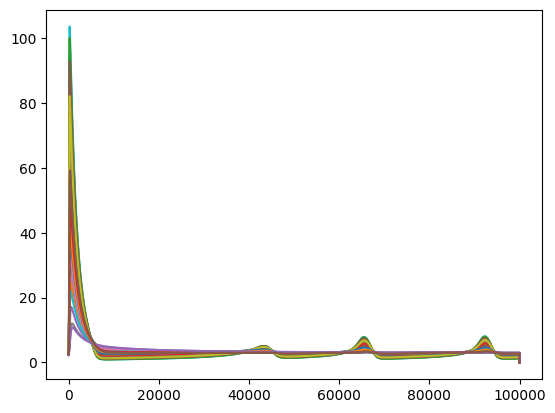

In [5]:
from matplotlib import pyplot as plt

signal = monitor.data(obs_var)

fig, ax = plt.subplots()
ax.plot(np.arange(signal.shape[0]), signal)
plt.show()

In [6]:
from neuronumba.tools.filters import BandPassFilter
from neuronumba.bold import BoldStephan2008

# Compute the bold signal from the simulation data
b = BoldStephan2008()
bold = b.compute_bold(signal, monitor.period)
# Apply a band pass filter
bpf = BandPassFilter(k=2, flp=0.01, fhi=0.1, tr=2000.0)
bold_filt = bpf.filter(bold)

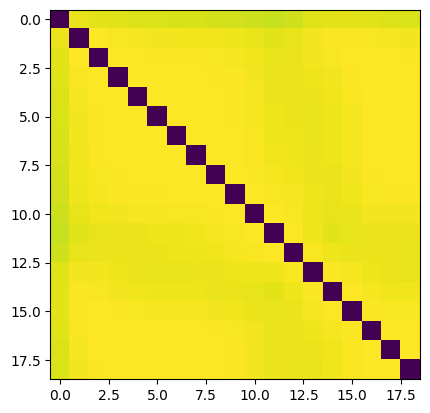

In [7]:
from neuronumba.observables.ph_fcd import PhFCD

ph_fcd = PhFCD()
simulated = ph_fcd.from_fmri(bold_filt)
signal = simulated['phFCD']  # from_fmri() method always return a dictionary with the results
# In this particular case, phFCD return the upper triangular part of the matrix. Use 
# buildFullMatrix to recover the full matrix
fullMatrix = ph_fcd.buildFullMatrix(signal)
# And plot!!!
fig, ax = plt.subplots()
ax.imshow(fullMatrix)
plt.show()

=== Sanity checks ===
signal (neural obs): shape=(100001, 66), dtype=float64, min=0, max=103.5, mean=3.938, std=5.603
bold (downsampled): shape=(40, 66), dtype=float64, min=0.03201, max=0.1192, mean=0.1133, std=0.005401
bold_filt (bandpass): shape=(40, 66), dtype=float64, min=-0.02926, max=0.04693, mean=0.001443, std=0.005871
phFCD vector length: 171
phFCD full matrix: shape=(19, 19), dtype=float64, min=0, max=0.9999, mean=0.9298, std=0.2198
=== Plotting ===


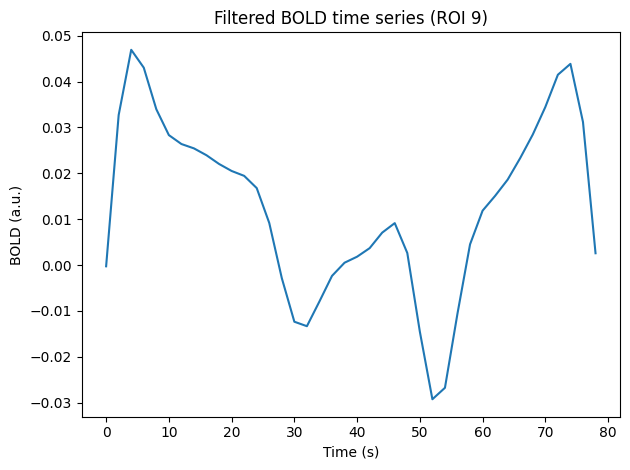

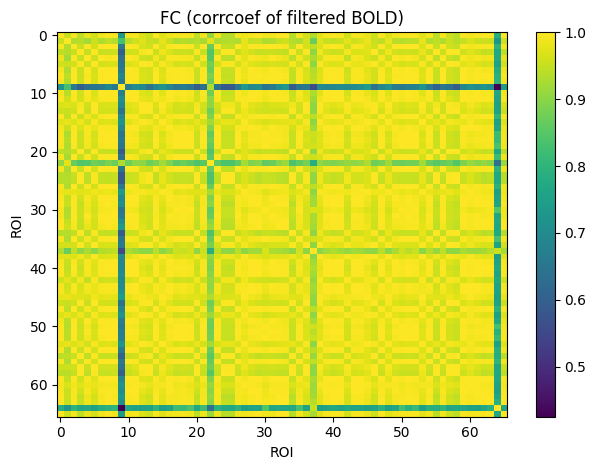

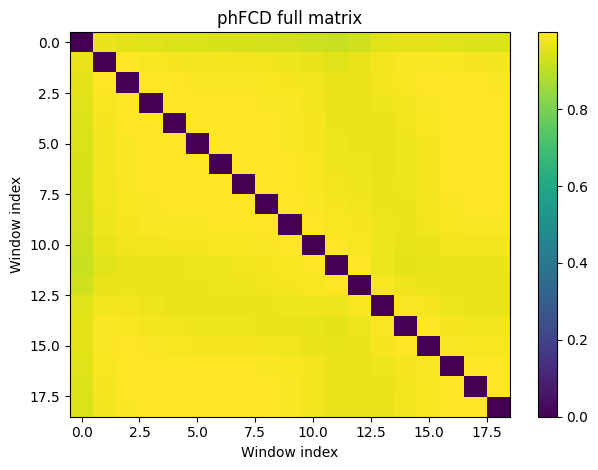

In [8]:
# One-shot neuronumba demo:
# SC -> simulate neural mass model -> generate BOLD -> bandpass filter -> compute phFCD
# Outputs: quick text sanity checks + a few diagnostic plots

import os
import numpy as np
import hdf5storage as sio
import matplotlib.pyplot as plt

from neuronumba.simulator.models import Naskar2021
from neuronumba.simulator.connectivity import Connectivity
from neuronumba.simulator.history import HistoryNoDelays
from neuronumba.simulator.integrators import EulerDeterministic
from neuronumba.simulator.monitors import RawSubSample
from neuronumba.simulator.simulator import Simulator

from neuronumba.bold import BoldStephan2008
from neuronumba.tools.filters import BandPassFilter
from neuronumba.observables.ph_fcd import PhFCD


def _print_shape_stats(name, x):
    x = np.asarray(x)
    print(
        f"{name}: shape={x.shape}, dtype={x.dtype}, "
        f"min={np.nanmin(x):.4g}, max={np.nanmax(x):.4g}, "
        f"mean={np.nanmean(x):.4g}, std={np.nanstd(x):.4g}"
    )


# -------------------------------
# 1) Load SC (h66) from repo data
# -------------------------------
nn_path = pathlib.Path.cwd().parent.resolve()
conn_66 = sio.loadmat(os.path.join(nn_path, "data", "h66.mat"))
weights = conn_66["weights"]
tract_lengths = conn_66["tract_lengths"]

# Large speed => (almost) no delays; HistoryNoDelays also ignores delays by design
con = Connectivity(weights=weights, lengths=tract_lengths, speed=1e10)

# -------------------------------
# 2) Build model + integrator + history + monitor
# -------------------------------
m = Naskar2021(g=1.0)

dt = 0.1  # ms
integ = EulerDeterministic(dt=dt)
history = HistoryNoDelays()

# Sample one observable every 1 ms
obs_var = "re"
monitor = RawSubSample(period=1.0, monitor_vars=m.get_var_info([obs_var]))

# -------------------------------
# 3) Run simulation (ms)
# -------------------------------
t_start_ms = 0
t_end_ms = 100000  # 100 s

sim = Simulator(connectivity=con, model=m, history=history, integrator=integ, monitors=[monitor])
sim.run(t_start_ms, t_end_ms)

signal = monitor.data(obs_var)  # (time, rois) sampled at period=1 ms

# -------------------------------
# 4) Neural -> BOLD -> bandpass
# -------------------------------
tr_ms = 2000.0
bold = BoldStephan2008(tr=tr_ms).compute_bold(signal, monitor.period)  # downsampled to TR grid (time, rois)
bpf = BandPassFilter(k=2, flp=0.01, fhi=0.1, tr=tr_ms)  # tr is in ms in this repo
bold_filt = bpf.filter(bold)  # keep (time, rois)

# -------------------------------
# 5) phFCD from filtered BOLD
# -------------------------------
ph = PhFCD()
out = ph.from_fmri(bold_filt)  # expects (time, rois)
fcd_vec = out["phFCD"]
fcd_mat = ph.buildFullMatrix(fcd_vec)

# -------------------------------
# 6) Sanity checks + plots
# -------------------------------
print("=== Sanity checks ===")
_print_shape_stats("signal (neural obs)", signal)
_print_shape_stats("bold (downsampled)", bold)
_print_shape_stats("bold_filt (bandpass)", bold_filt)
print(f"phFCD vector length: {len(fcd_vec)}")
_print_shape_stats("phFCD full matrix", fcd_mat)

print("=== Plotting ===")

# Pick a non-flat ROI automatically (highest variance)
roi_idx = int(np.nanargmax(np.nanvar(bold_filt, axis=0)))
t_bold_s = np.arange(bold_filt.shape[0]) * (tr_ms / 1000.0)

plt.figure()
plt.plot(t_bold_s, bold_filt[:, roi_idx])
plt.xlabel("Time (s)")
plt.ylabel("BOLD (a.u.)")
plt.title(f"Filtered BOLD time series (ROI {roi_idx})")
plt.tight_layout()
plt.show()

# FC from filtered BOLD (time x rois)
fc_mat = np.corrcoef(bold_filt, rowvar=False)

plt.figure()
plt.imshow(fc_mat, aspect="auto")
plt.title("FC (corrcoef of filtered BOLD)")
plt.xlabel("ROI")
plt.ylabel("ROI")
plt.colorbar()
plt.tight_layout()
plt.show()

plt.figure()
plt.imshow(fcd_mat, aspect="auto")
plt.title("phFCD full matrix")
plt.xlabel("Window index")
plt.ylabel("Window index")
plt.colorbar()
plt.tight_layout()
plt.show()